In [1]:
import pandas as pd
import numpy as np
import datetime
import re
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from IPython.display import display, Image

## 0. Start Chromedriver
- **`CHROME_VERSION`**: go to your chrome settings and check your version of chrome. If your version does not match the version shown below, download the correct version of the Chromedriver from [here](https://chromedriver.chromium.org/downloads) and append the version number to the end of its name. e.g. if you have Chrome version 80, you should rename `chromedriver.exe` to `chromedriver80.exe`
  - **`Options()`**: adding `headless` and `window-size` arguments allows us to use Chromedriver without a GUI.

In [2]:
CHROME_VERSION='79'  # change this to match Chrome version on host machine

options = Options()
options.add_argument('headless')
options.add_argument('window-size=1200x600')
driver = webdriver.Chrome(f'./chromedriver/chromedriver{CHROME_VERSION}.exe', options=options)

---
## 1. Load upcoming Super Rugby match odds

In [3]:
driver.get( "https://www.oddsportal.com/rugby-union/world/super-rugby/")
driver.implicitly_wait(5)  # give page time to load all content

We can take a peek at what the Chromedriver sees using the `get_screenshot_as_png()` method on the driver object.

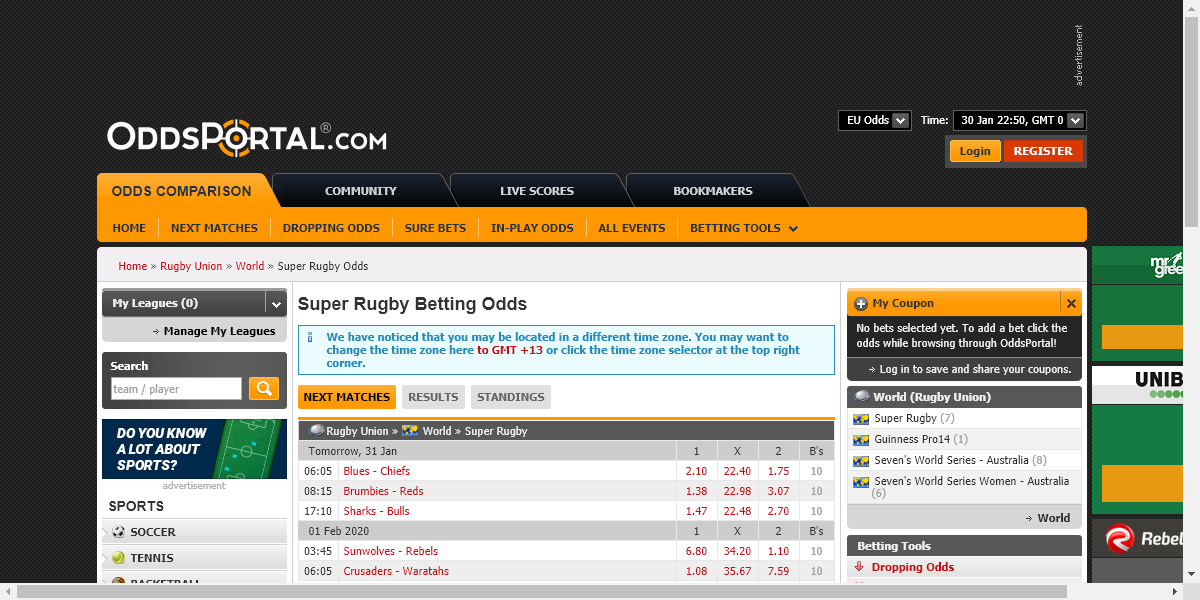

In [4]:
display(
    Image(
        driver.get_screenshot_as_png(),
        width=800,
        height=400
    )
)

In [5]:
table = driver.find_element_by_xpath('//*[@id="tournamentTable"]')

In [6]:
table.find_elements_by_xpath('//*[@id="tournamentTable"]/tbody/tr[7]')

[<selenium.webdriver.remote.webelement.WebElement (session="1439445bd0cd49a273e06bc6af2d5a1d", element="439e373a-0755-496e-9dc9-b32fbb355b82")>]

In [7]:
table.text

"Rugby Union\n»\n World\n»\nSuper Rugby\nTomorrow, 31 Jan 1 X 2 B's\n06:05 Blues - Chiefs\n2.10\n22.40\n1.75\n10\n08:15 Brumbies - Reds\n1.38\n22.98\n3.07\n10\n17:10 Sharks - Bulls\n1.47\n22.48\n2.70\n10\n01 Feb 2020 1 X 2 B's\n03:45 Sunwolves - Rebels\n6.80\n34.20\n1.10\n10\n06:05 Crusaders - Waratahs\n1.08\n35.67\n7.59\n10\n13:05 Stormers - Hurricanes\n1.70\n21.72\n2.18\n10\n21:40 Jaguares - Lions\n1.24\n25.43\n4.07\n9"

In [8]:
table_rows = table.text.split('\n')
table_rows[:25]

['Rugby Union',
 '»',
 ' World',
 '»',
 'Super Rugby',
 "Tomorrow, 31 Jan 1 X 2 B's",
 '06:05 Blues - Chiefs',
 '2.10',
 '22.40',
 '1.75',
 '10',
 '08:15 Brumbies - Reds',
 '1.38',
 '22.98',
 '3.07',
 '10',
 '17:10 Sharks - Bulls',
 '1.47',
 '22.48',
 '2.70',
 '10',
 "01 Feb 2020 1 X 2 B's",
 '03:45 Sunwolves - Rebels',
 '6.80',
 '34.20']

In [9]:
# remove table header (first 5 lines)
table_rows = table_rows[5:]

In [10]:
# split list up by dates
date_idx = []
idx = 0
for row in table_rows:
    if "1 X 2 B's" in row:
        print(row)
        date_idx.append(idx)
    idx += 1

Tomorrow, 31 Jan 1 X 2 B's
01 Feb 2020 1 X 2 B's


In [11]:
date_idx

[0, 16]

In [12]:
# schema of dataframe
df = {
    'Date': [],
    'Home Team': [],
    'Away Team': [],
    'Home Score': [],
    'Away Score': [],
    'Play-off Game?': [],
    'Home Odds': [],
    'Draw Odds': [],
    'Away Odds': [],
    'Bookmakers Surveyed': []
}

# for each separate date
for i in range(len(date_idx)):
    
    # extract date
    date = table_rows[date_idx[i]]
    date = date.replace(" 1 X 2 B's", '')
    
    # remove unnecessary text
    if 'Tomorrow' in date or 'Today' in date:
        date = date[date.find(',')+2: ] + ' ' + str(datetime.datetime.now().year)
        
    date = date.replace(' ', '-')
    
    first_match = date_idx[i]+1
    
    fixtures = []
    
    if i < len(date_idx)-1:
        last_match = date_idx[i+1]
        fixtures = table_rows[first_match:last_match]
        
    else:
        fixtures = table_rows[first_match:]
        
    fixtures = np.array(fixtures).reshape(-1, 5)
    date_col = np.repeat([date], fixtures.shape[0])
    fixtures = np.hstack((date_col.reshape(-1, 1), fixtures))
    
    # add each row to dictionary
    for f in fixtures:
        df['Date'].append(f[0])
        df['Home Team'].append(f[1])
        df['Away Team'].append(f[1])
        df['Home Score'].append(0)
        df['Away Score'].append(0)
        df['Play-off Game?'].append('N')
        df['Home Odds'].append(f[2])
        df['Draw Odds'].append(f[3])
        df['Away Odds'].append(f[4])
        df['Bookmakers Surveyed'].append(f[-1])

# convert dictionary to dataframe
df = pd.DataFrame(df)
df.head()

,Date,Home Team,Away Team,Home Score,Away Score,Play-off Game?,Home Odds,Draw Odds,Away Odds,Bookmakers Surveyed
0,31-Jan-2020,06:05 Blues - Chiefs,06:05 Blues - Chiefs,0,0,N,2.10,22.40,1.75,10
1,31-Jan-2020,08:15 Brumbies - Reds,08:15 Brumbies - Reds,0,0,N,1.38,22.98,3.07,10
2,31-Jan-2020,17:10 Sharks - Bulls,17:10 Sharks - Bulls,0,0,N,1.47,22.48,2.70,10
3,01-Feb-2020,03:45 Sunwolves - Rebels,03:45 Sunwolves - Rebels,0,0,N,6.80,34.20,1.10,10
4,01-Feb-2020,06:05 Crusaders - Waratahs,06:05 Crusaders - Waratahs,0,0,N,1.08,35.67,7.59,10


In [13]:
def get_home(s):
    '''find the text between the kick-off time and the dash'''
    return re.search(r'[0-2][0-9]:[0-6][0-9](.*?)-', s).group(1).strip()

def get_away(s):
    '''find the last word of text'''
    return s.split()[-1]

print(get_home('06:05 Blues - Chiefs'))
print(get_away('06:05 Blues - Chiefs'))

Blues
Chiefs


In [14]:
df['Home Team'] = df['Home Team'].apply(get_home)
df['Away Team'] = df['Away Team'].apply(get_away)

df.head()

,Date,Home Team,Away Team,Home Score,Away Score,Play-off Game?,Home Odds,Draw Odds,Away Odds,Bookmakers Surveyed
0,31-Jan-2020,Blues,Chiefs,0,0,N,2.10,22.40,1.75,10
1,31-Jan-2020,Brumbies,Reds,0,0,N,1.38,22.98,3.07,10
2,31-Jan-2020,Sharks,Bulls,0,0,N,1.47,22.48,2.70,10
3,01-Feb-2020,Sunwolves,Rebels,0,0,N,6.80,34.20,1.10,10
4,01-Feb-2020,Crusaders,Waratahs,0,0,N,1.08,35.67,7.59,10
